# Plotting timeseries of Arctic Regional ice area

* **Description**: Plots future timeseries by month and region
* **Input data**: Processed rufmod and cesm2-le regional avg netcdf files
* **Output data**: Timeseries plots in png format
* **Creator**: Alice DuVivier
* **Date**: August 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.stats import ttest_ind


## Read in the processed data

This reads in pre-processed regional total avrage mass budget terms for the Arctic.

In [2]:
# list the variables to load
var_in = 'aice'


In [3]:
# set base directory where all data live
data_dir = '/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/fig_5_ice_area_regional/'

# set file names
fin_le = 'CESM2-LE_all_transient_regional_total_'+var_in
fin_smooth = 'rufmod_all_transient_regional_total_'+var_in

In [4]:
ds_le = xr.open_dataset(data_dir+fin_le+'.nc',decode_times=True)
ds_smooth = xr.open_dataset(data_dir+fin_smooth+'.nc',decode_times=True)

In [5]:
# double check that year/month is not shifted incorrectly
ds_le.coords['time.month']
ds_smooth.coords['time.month']

<xarray.DataArray 'month' (time: 1032)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [6]:
# check what regions we have totals for
ds_le.region

# should match...
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

In [7]:
print(ds_le.units)
print(ds_le.longname)

total_le = ds_le['regional_totals']
total_smooth = ds_smooth['regional_totals']

km^2
regional total ice area


In [8]:
total_le

<xarray.DataArray 'regional_totals' (member_id: 50, time: 1032, region: 14)>
[722400 values with dtype=float64]
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) object 'r10i1181p1f1' ... 'r9i1301p1f1'
  * region     (region) object 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'

In [9]:
#convert units
if var_in == 'aice':
    # convert to 1000000's of km3
    total_le = total_le/(1000000.0)
    total_smooth = total_smooth/(1000000.0)
    units = 'Total ice area ($10^{6}$ $km^{2}$)'
else:
    out_tag = 'ice_vol'
    label = 'Ice Volume'
    # convert to 1000's of km3
    total_le = total_le/(1000.0)
    total_smooth = total_smooth/(1000.0)
    units = 'Total ice volume ($10^{3}$ $km^{3}$)'

## Calculate seasonal means

In [10]:
season_names = ['OND','JFM', 'AMJ', 'JAS']

In [11]:
# find total years
xarr_le = total_le.coords['time.year'][(total_le.coords['time.month']==1)]
xarr_smooth = total_smooth.coords['time.year'][(total_smooth.coords['time.month']==1)]

In [12]:
# Loop through seasons - rufmod
print('Calculating Seasonal Means - SMOOTH')

# make numpy array to fill and specify dimensions we want
seas_array_smooth = np.zeros([len(total_smooth.member_id),len(season_names),len(xarr_smooth),len(total_smooth.region)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp0 = total_smooth.isel(time=total_smooth.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp0 = total_smooth.isel(time=total_smooth.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp0 = total_smooth.isel(time=total_smooth.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp0 = total_smooth.isel(time=total_smooth.time.dt.month.isin([10,11,12]))

    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_smooth:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp0a = temp0.isel(time=temp0.time.dt.year.isin([yy]))
        seas_array_smooth[:,s_count,y_count,:] = temp0a.mean(dim='time')
        

Calculating Seasonal Means - SMOOTH
OND
JFM
AMJ
JAS


In [13]:
# Loop through seasons - CESM2-LE
print('Calculating Seasonal Means - CESM2-LE')

# make numpy array to fill and specify dimensions we want
seas_array_le = np.zeros([len(total_le.member_id),len(season_names),len(xarr_le),len(total_le.region)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp0 = total_le.isel(time=total_le.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp0 = total_le.isel(time=total_le.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp0 = total_le.isel(time=total_le.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp0 = total_le.isel(time=total_le.time.dt.month.isin([10,11,12]))

    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_le:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp0a = temp0.isel(time=temp0.time.dt.year.isin([yy]))
        seas_array_le[:,s_count,y_count,:] = temp0a.mean(dim='time')
        

Calculating Seasonal Means - CESM2-LE
OND
JFM
AMJ
JAS


In [14]:
print(seas_array_le.shape)
print(seas_array_smooth.shape)

(50, 4, 86, 14)
(5, 4, 86, 14)


In [15]:
# convert the numpy array to a xarray
seas_le = xr.DataArray(seas_array_le,dims=('member_id','season','time','region'))
seas_smooth = xr.DataArray(seas_array_smooth,dims=('member_id','season','time','region'))


In [16]:
# set coordinate arrays
seas_le['season'] = season_names
seas_le['time'] = xarr_le
seas_le['member_id'] = total_le['member_id']
seas_le['region'] = total_le['region']

seas_smooth['season'] = season_names
seas_smooth['time'] = xarr_smooth
seas_smooth['member_id'] = total_smooth['member_id']
seas_smooth['region'] = total_smooth['region']

In [17]:
seas_le.shape

(50, 4, 86, 14)

## Calculate ensemble means & significance

In [18]:
# calculate ensemble means
seas_ens_mean_le = seas_le.mean(dim='member_id')
seas_ens_mean_smooth = seas_smooth.mean(dim='member_id')

In [19]:
# calculate statistical significance
sigval = 0.05

# calculate statistical significance
tval,pval = ttest_ind(seas_le,seas_smooth,axis=0,equal_var=False)
seas_ens_mean_le_sig = seas_ens_mean_le.where(pval <= sigval)
seas_ens_mean_smooth_sig = seas_ens_mean_smooth.where(pval <= sigval)

In [20]:
seas_le

<xarray.DataArray (member_id: 50, season: 4, time: 86, region: 14)>
array([[[[7.10623301e+00, 3.88546052e-01, 3.07077585e-01, ...,
          5.62939546e+00, 2.43174914e+00, 8.24855559e-01],
         [7.48030501e+00, 3.09110881e-01, 1.80113663e-01, ...,
          6.16602668e+00, 2.04240669e+00, 8.16995235e-01],
         [6.62210601e+00, 3.53785897e-01, 2.32386316e-01, ...,
          5.49942304e+00, 1.93264379e+00, 8.19729768e-01],
         ...,
         [1.20902789e+00, 3.58980380e-02, 3.77860317e-02, ...,
          1.05299276e+00, 4.08399864e-01, 2.94289358e-01],
         [7.50220020e-01, 1.15924767e-01, 8.61491542e-02, ...,
          4.86839443e-01, 3.41496381e-01, 3.14081708e-01],
         [4.13797913e-01, 3.83916058e-02, 5.48822910e-02, ...,
          2.87517989e-01, 1.87711021e-01, 1.77577885e-01]],

        [[1.28195037e+01, 9.61660813e-01, 6.65266825e-01, ...,
          8.71925088e+00, 2.95416490e+00, 8.28784866e-01],
         [1.26241937e+01, 9.91328163e-01, 6.01340945e-01, ...,
          8.56762419e+00, 2.94985305e+00, 8.27894903e-01],
         [1.25090752e+01, 9.13486208e-01, 5.74920744e-01, ...,
          8.62168834e+00, 2.87478530e+00, 8.27989563e-01],
...
         [8.08089907e+00, 5.89832711e-01, 3.24344065e-01, ...,
          6.19204912e+00, 2.30173285e+00, 7.45657019e-01],
         [7.67397645e+00, 6.18451024e-01, 3.18878081e-01, ...,
          5.99617720e+00, 2.35710279e+00, 7.74554549e-01],
         [7.34358326e+00, 7.07509568e-01, 2.57856211e-01, ...,
          5.52862187e+00, 2.49187394e+00, 7.42441566e-01]],

        [[3.50390337e+00, 3.45563791e-02, 1.44549066e-01, ...,
          2.95200754e+00, 1.34284021e+00, 5.85287244e-01],
         [3.10593517e+00, 3.03454221e-02, 1.73624280e-01, ...,
          2.57360296e+00, 9.91565648e-01, 4.83464122e-01],
         [4.59447616e+00, 9.76797613e-02, 2.19182892e-01, ...,
          3.78903886e+00, 1.68643177e+00, 7.22227175e-01],
         ...,
         [1.65212052e-01, 2.33827650e-03, 2.91605995e-03, ...,
          1.17825473e-01, 6.25589875e-02, 2.71914422e-02],
         [2.18329557e-01, 7.31984241e-03, 1.61953043e-03, ...,
          1.69025836e-01, 1.32712421e-01, 8.61069796e-02],
         [2.12262354e-01, 7.96670576e-03, 2.83890666e-03, ...,
          1.49548765e-01, 1.23634072e-01, 6.33054526e-02]]]])
Coordinates:
  * season     (season) <U3 'OND' 'JFM' 'AMJ' 'JAS'
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * member_id  (member_id) object 'r10i1181p1f1' ... 'r9i1301p1f1'
  * region     (region) object 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'

In [21]:
# bootstrap the CESM2-LE 1000 times
n_bs=1000
seas_bs_array_le = np.zeros([len(season_names),len(xarr_le),len(seas_le.region),n_bs])

for ii in range(n_bs):
    # choose random ensemble member numbers
    mem1=np.random.choice(range(0,49))
    mem2=np.random.choice(range(0,49))
    mem3=np.random.choice(range(0,49))
    mem4=np.random.choice(range(0,49))
    mem5=np.random.choice(range(0,49)) 
    # now average those random ensembles
    temp = np.stack((seas_le.isel(member_id=mem1),seas_le.isel(member_id=mem2),seas_le.isel(member_id=mem3),
                     seas_le.isel(member_id=mem4),seas_le.isel(member_id=mem5)),axis=-1)
    seas_bs_array_le[:,:,:,ii]=np.mean(temp,axis=3)

In [22]:
seas_bs_array_le.shape

(4, 86, 14, 1000)

In [23]:
# convert the numpy array to a xarray for easier plotting
seas_bs_le = xr.DataArray(seas_bs_array_le,dims=('season','time','region','bootstrap_num'))

In [24]:
# assign coordinate arrays
seas_bs_le['season'] = seas_le.season
seas_bs_le['time']= seas_le.time
seas_bs_le['region'] = seas_le.region

### Plotting!

In [25]:
mask_sub = ['ArcOc_mask']

In [26]:
#set some labeling info for plots
out_tag = 'fig_5_ice_area'

In [27]:
titles = ['a) Autumn', 'b) Winter', 'c) Spring', 'd) Summer']

Plotting timeseries for region ArcOc_mask


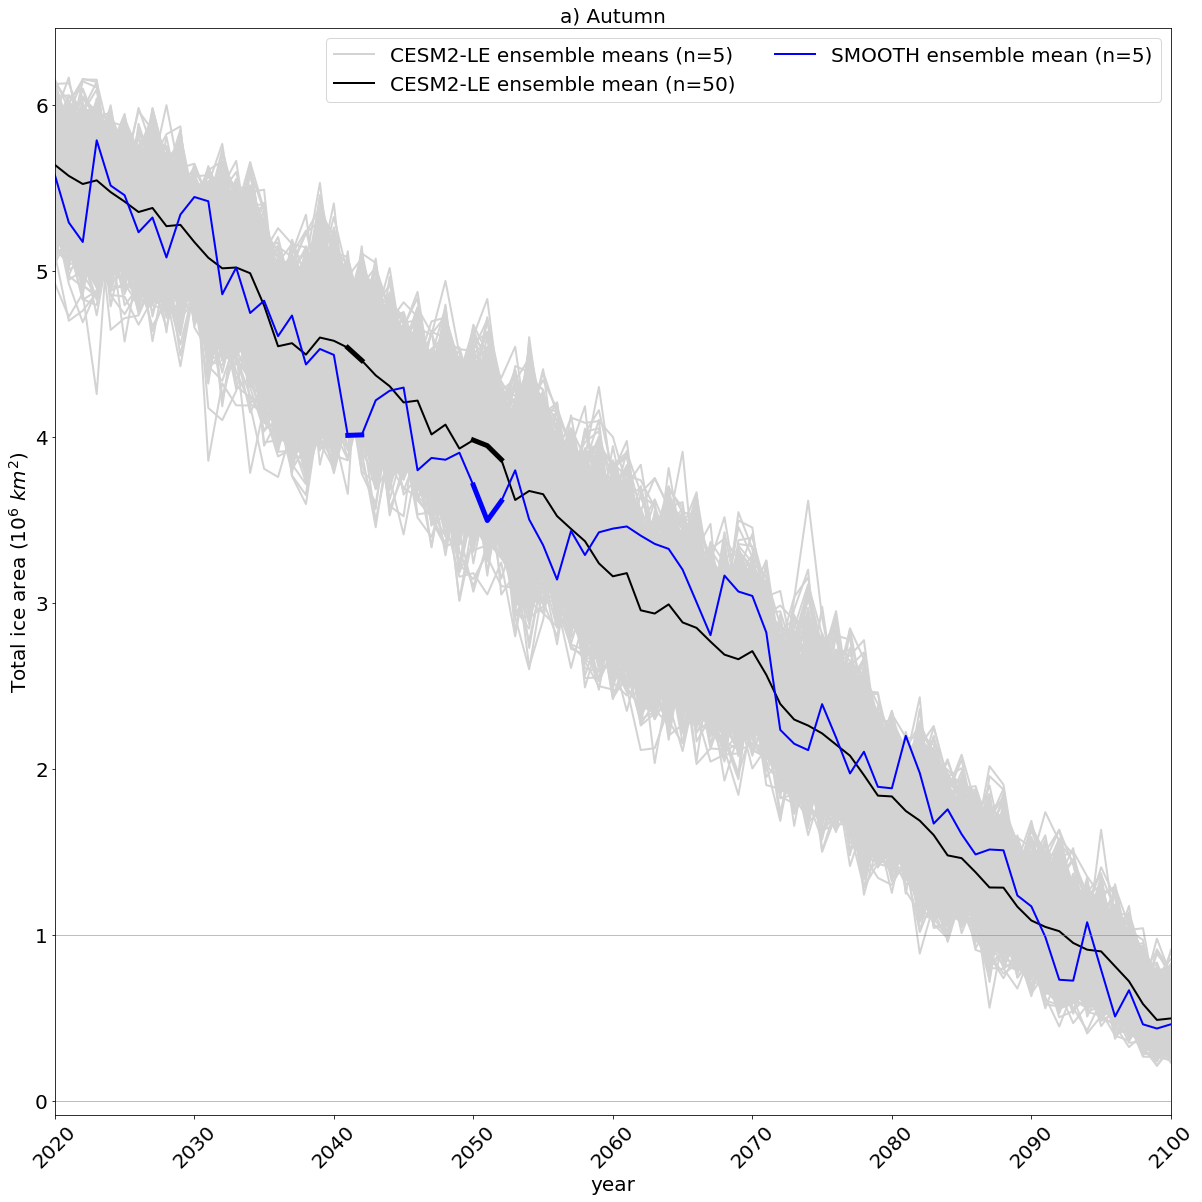

In [28]:
# Plot regional time series ensemble means as a panel plot
# Loop through subset of regions

for reg in mask_sub:
    print('Plotting timeseries for region '+reg)
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = out_tag+'_legend'
    # now loop through seasons to create subpanels
    for ss in season_names[0:1]:
        if ss == 'OND':
            s_count = 1
        else:
            s_count = s_count+1
        
        # CESM2-LE: subset the data for this season
        temp_le     = seas_bs_le.sel(region=reg,season=ss)
        temp_le_ens = seas_ens_mean_le.sel(region=reg,season=ss)
        temp_le_sig = seas_ens_mean_le_sig.sel(region=reg,season=ss)
        
        # rufmod: subset the data for this season
        temp_smooth_ens = seas_ens_mean_smooth.sel(region=reg,season=ss)
        temp_smooth_sig = seas_ens_mean_smooth_sig.sel(region=reg,season=ss)
                
        # Make subplot - note it's nrow x ncol x index (starting upper left)
        ax = fig.add_subplot(1,1,s_count)        
        # plot the bootstrapped means
        for ii in range(n_bs):
            ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='_nolegend_');
        ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='CESM2-LE ensemble means (n=5)')
        # plot ensemble means
        ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=2)
        ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=2)
        # plot when ensemble means are significant
        ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
        ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   
        
        # finish up plot
        plt.title(titles[s_count -1],fontsize=20)
        plt.xlabel('year',fontsize=20)
        plt.xticks(fontsize=20, rotation=45)
        plt.xlim([2020,2100])
        plt.ylabel(units,fontsize=20)
        plt.yticks(fontsize=20)
        plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
        plt.axhline(y=1, color='grey', linestyle='-', linewidth=0.5)
        plt.legend(ncol=2,fontsize=20)
        
    # Finalize figure and save
    #fig.suptitle('Ensemble mean terms for '+label+' '+reg,fontsize=20, y=0.95)  
    #fig.subplots_adjust(wspace=0.2, hspace=0.25)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

Plotting timeseries for region ArcOc_mask


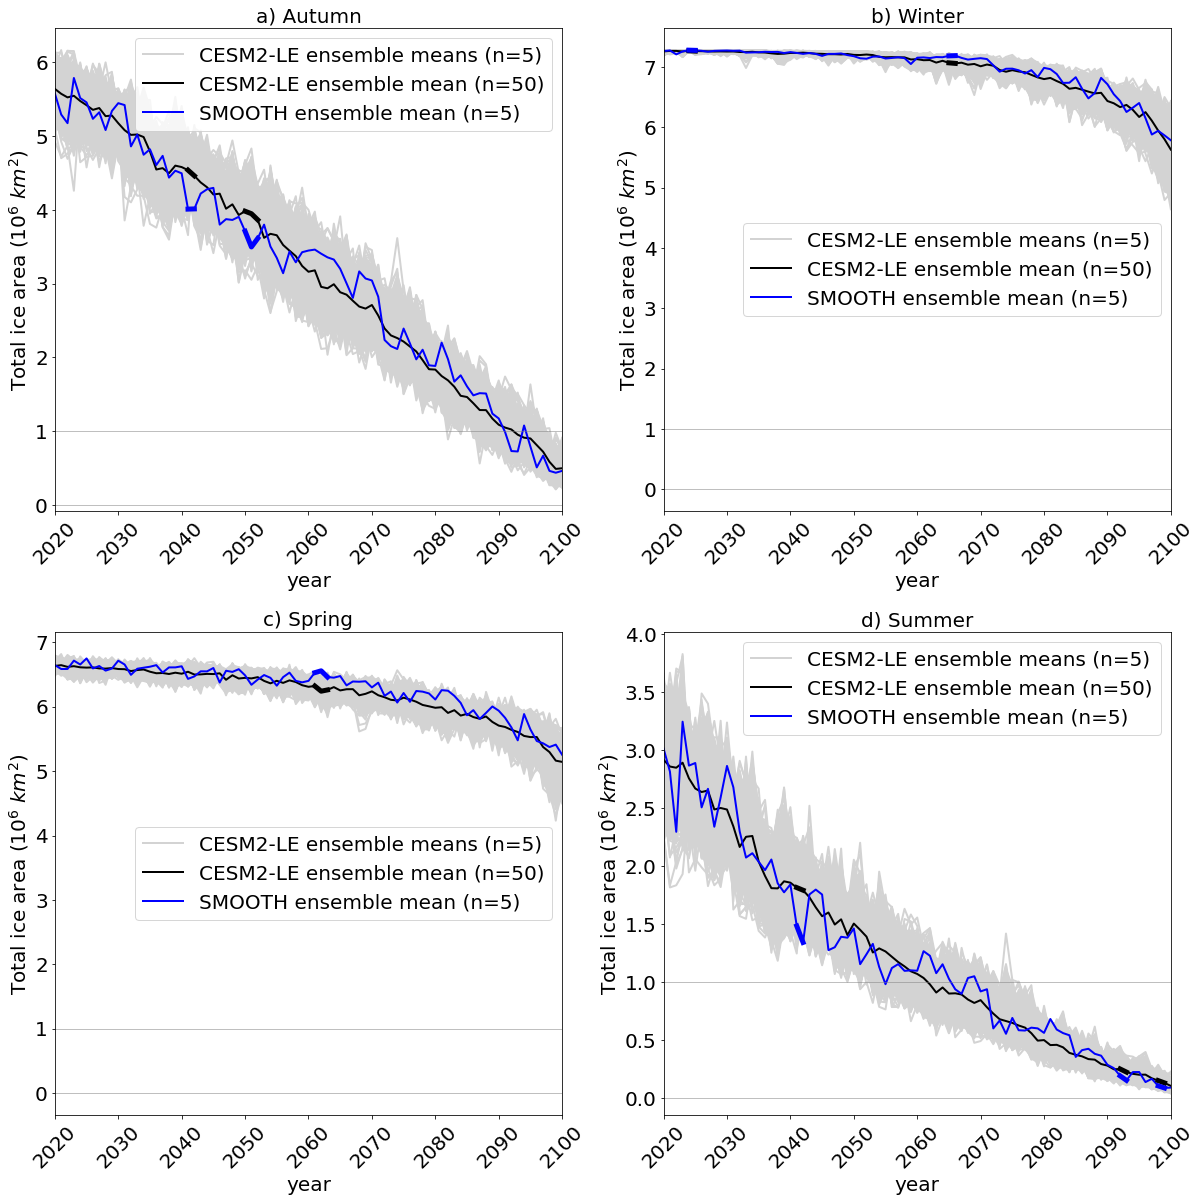

In [29]:
# Plot regional time series ensemble means as a panel plot
# Loop through subset of regions

for reg in mask_sub:
    print('Plotting timeseries for region '+reg)
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = out_tag+'_timeseries_'+reg+'_all_seasons'
    # now loop through seasons to create subpanels
    for ss in season_names:
        if ss == 'OND':
            s_count = 1
        else:
            s_count = s_count+1
        
        # CESM2-LE: subset the data for this season
        temp_le     = seas_bs_le.sel(region=reg,season=ss)
        temp_le_ens = seas_ens_mean_le.sel(region=reg,season=ss)
        temp_le_sig = seas_ens_mean_le_sig.sel(region=reg,season=ss)
        
        # rufmod: subset the data for this season
        temp_smooth_ens = seas_ens_mean_smooth.sel(region=reg,season=ss)
        temp_smooth_sig = seas_ens_mean_smooth_sig.sel(region=reg,season=ss)
                
        # Make subplot - note it's nrow x ncol x index (starting upper left)
        ax = fig.add_subplot(2,2,s_count)        
        # plot the bootstrapped means
        for ii in range(n_bs):
            ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='_nolegend_');
        ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='CESM2-LE ensemble means (n=5)')
        # plot ensemble means
        ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=2)
        ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=2)
        # plot when ensemble means are significant
        ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
        ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   
        
        # finish up plot
        plt.title(titles[s_count -1],fontsize=20)
        plt.xlabel('year',fontsize=20)
        plt.xticks(fontsize=20, rotation=45)
        plt.xlim([2020,2100])
        plt.ylabel(units,fontsize=20)
        plt.yticks(fontsize=20)
        plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
        plt.axhline(y=1, color='grey', linestyle='-', linewidth=0.5)
        plt.legend(ncol=1,fontsize=20)
        
    # Finalize figure and save
    #fig.suptitle('Ensemble mean terms for '+label+' '+reg,fontsize=20, y=0.95)  
    fig.subplots_adjust(wspace=0.2, hspace=0.25)
    #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

Plotting timeseries for region ArcOc_mask


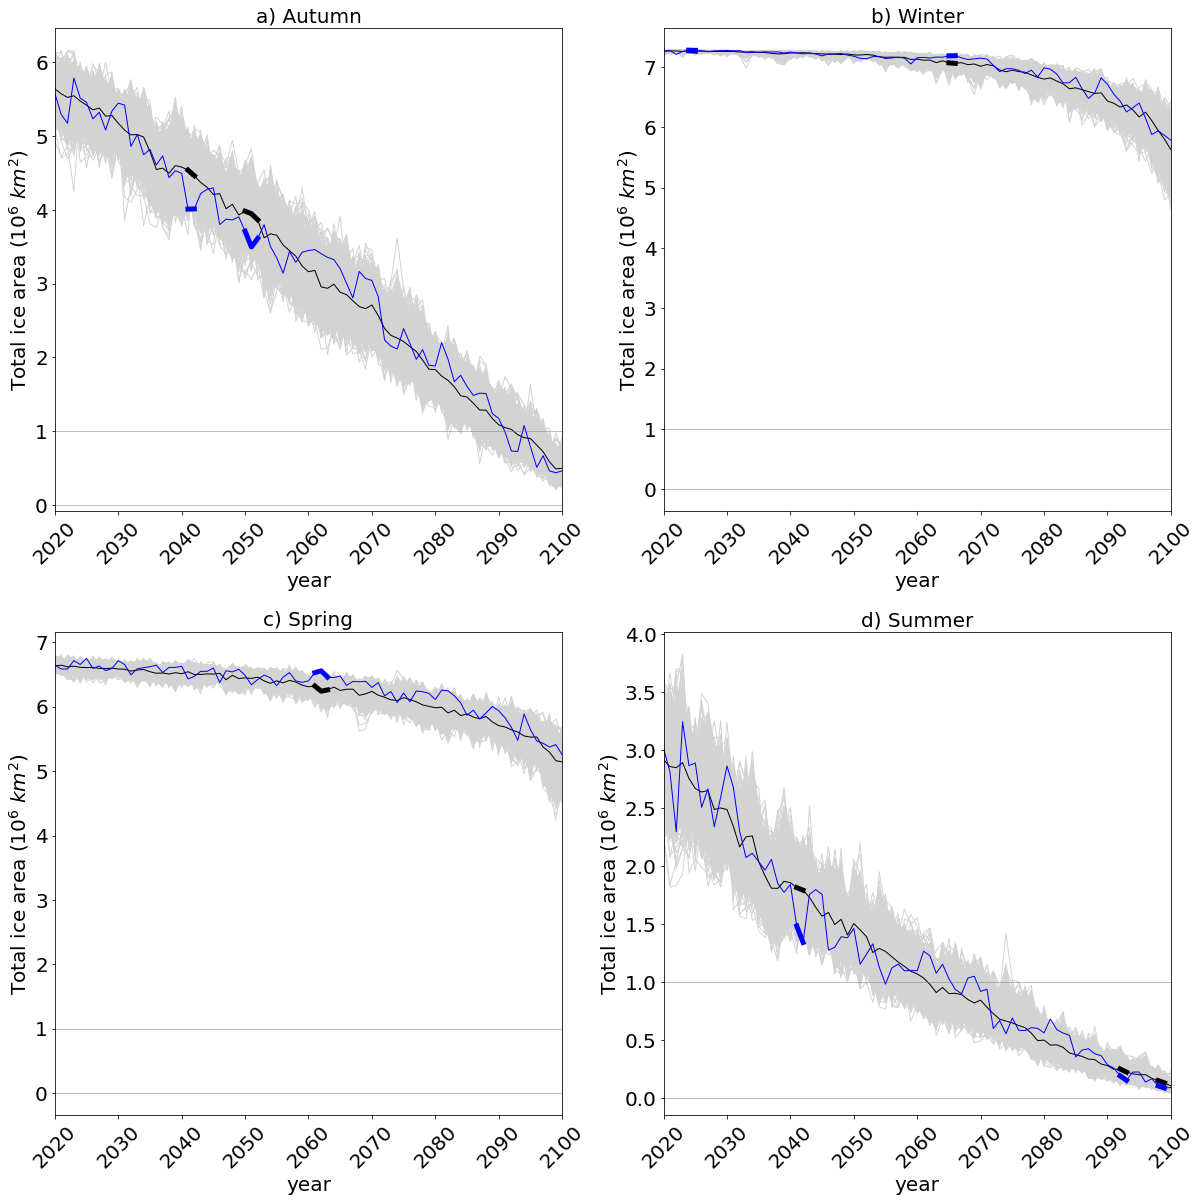

In [30]:
# Plot regional time series ensemble means as a panel plot
# Loop through subset of regions

for reg in mask_sub:
    print('Plotting timeseries for region '+reg)
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = out_tag+'_timeseries_'+reg+'_all_seasons'
    # now loop through seasons to create subpanels
    for ss in season_names:
        if ss == 'OND':
            s_count = 1
        else:
            s_count = s_count+1
        
        # CESM2-LE: subset the data for this season
        temp_le     = seas_bs_le.sel(region=reg,season=ss)
        temp_le_ens = seas_ens_mean_le.sel(region=reg,season=ss)
        temp_le_sig = seas_ens_mean_le_sig.sel(region=reg,season=ss)
        
        # rufmod: subset the data for this season
        temp_smooth_ens = seas_ens_mean_smooth.sel(region=reg,season=ss)
        temp_smooth_sig = seas_ens_mean_smooth_sig.sel(region=reg,season=ss)
                
        # Make subplot - note it's nrow x ncol x index (starting upper left)
        ax = fig.add_subplot(2,2,s_count)        
        # plot the bootstrapped means
        for ii in range(n_bs):
            ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=1,label='_nolegend_');
        ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=1,label='CESM2-LE ensemble means (n=5)')
        # plot ensemble means
        ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=1)
        ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=1)
        # plot when ensemble means are significant
        ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
        ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   
        
        # finish up plot
        plt.title(titles[s_count -1],fontsize=20)
        plt.xlabel('year',fontsize=20)
        plt.xticks(fontsize=20, rotation=45)
        plt.xlim([2020,2100])
        plt.ylabel(units,fontsize=20)
        plt.yticks(fontsize=20)
        plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
        plt.axhline(y=1, color='grey', linestyle='-', linewidth=0.5)
        #plt.legend(ncol=1,fontsize=20)
        
    # Finalize figure and save
    #fig.suptitle('Ensemble mean terms for '+label+' '+reg,fontsize=20, y=0.95)  
    fig.subplots_adjust(wspace=0.2, hspace=0.25)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)